In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [44]:
data = np.loadtxt(open('../00-Dataset/mnist_train_small.csv', 'rb'), delimiter=',')
originalData = data

In [45]:
# remove rows containing label = 7

rowsWith7 = data[data[:,0]==7]
data = data[data[:,0]!=7]

In [46]:
data.shape
labels = data[:,0]
data = data[:,1:]


In [47]:
# normalize the data to a range of [0, 1]
dataNorm = data/np.max(data)

In [60]:
rowsWith7Labels = rowsWith7[:,0]
rowsWith7Data = rowsWith7[:,1:]

In [61]:
rowsWith7DataNorm = rowsWith7Data/np.max(rowsWith7Data)

In [62]:
rowsWith7DataNorm.shape

(2126, 784)

In [63]:
rowsWith7NormDataT = torch.tensor(rowsWith7DataNorm).float()
rowsWith7NormLabelsT = torch.tensor(rowsWith7Labels).long()

In [51]:
dataNorm.shape

(17874, 784)

In [50]:
# convert data to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

# train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, train_size = 0.9)

train_data = TensorDataset(dataT, labelsT)
# test_data = TensorDataset(test_data, test_labels)

batchSize = 32
train_loader = DataLoader(train_data, batch_size=batchSize, drop_last=True, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=test_data.__len__())


In [52]:
%whos

Variable            Type             Data/Info
----------------------------------------------
ANN                 Model            Model(\n  (input): Linear<...>eatures=10, bias=True)\n)
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
Model               type             <class '__main__.Model'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                  ndarray          2: 2 elems, type `object`, 16 bytes
batchSize           int              32
data                ndarray          17874x784: 14013216 elems, type `float64`, 112105728 bytes (106.912353515625 Mb)
dataNorm            ndarray          17874x784: 14013216 elems, type `float64`, 112105728 bytes (106.912353515625 Mb)
dataT               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
fig                 Figure           Figure(

In [53]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.input = nn.Linear(784, 64)
        self.h1 = nn.Linear(64, 32)
        self.h2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = torch.log_softmax(self.output(x), axis=1)
        # log_softmax() because of NLLLoss instead of CrossEntropyLoss

        return x

In [54]:
def getModel():
    ANN = Model()
    lossFunction = nn.NLLLoss()
    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=0.01)

    return ANN, lossFunction, optimizer

In [55]:
def trainModel(ANN, lossFunction, optimizer):
    epochs = 60

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = ANN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)
    return trainAcc, testAcc, losses, ANN

In [56]:
ANN, lossFunction, optimizer = getModel()
trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer)

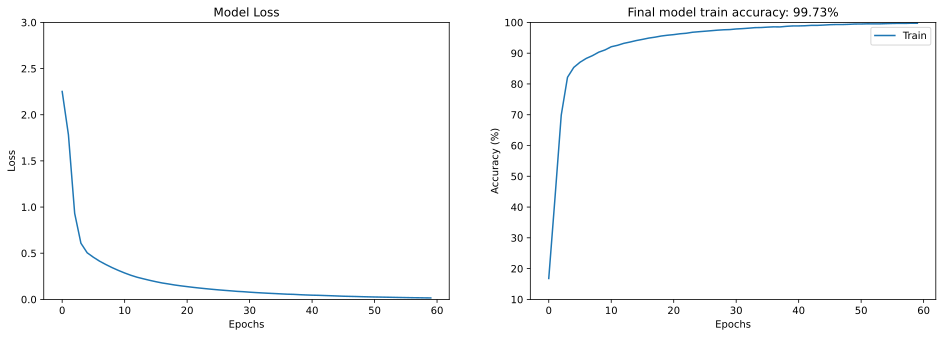

In [58]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')
ax[1].plot(trainAcc, label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model train accuracy: {trainAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## Inspect the result in more details

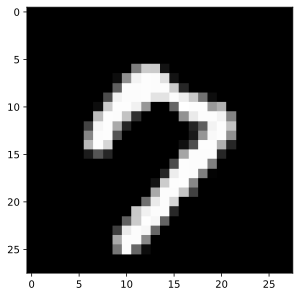

In [72]:
plt.imshow(np.reshape(rowsWith7NormDataT[1232,:], (28, 28)), cmap = 'gray')

In [87]:
with torch.no_grad():
    predictions = ANN(rowsWith7NormDataT).detach()

guesses = torch.argmax(predictions, axis=1).detach() # taking argmax here itself rather than taking with each operations below
guesses

tensor([0, 9, 3,  ..., 9, 9, 1])

In [88]:
someRand7s = np.random.choice(len(rowsWith7NormDataT), 12)

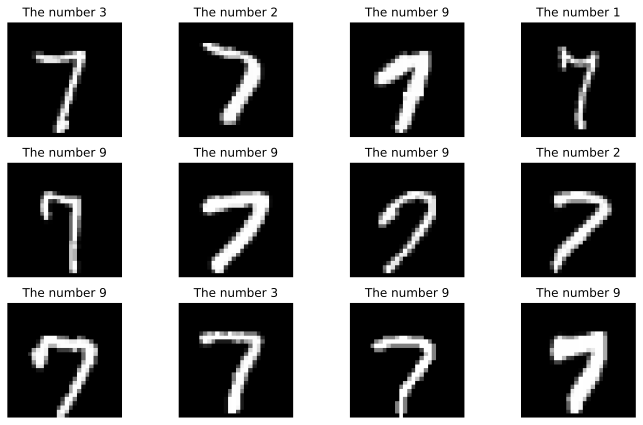

In [89]:
fig, axs = plt.subplots(3,4, figsize=(10,6))

for i, ax in enumerate(axs.flatten()):
    thisimg = rowsWith7NormDataT[someRand7s[i]].view(28, 28)
    ax.imshow(thisimg, cmap = 'gray')
    ax.set_title(f'The number {guesses[someRand7s[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

[0 1 2 3 4 5 6 8 9]


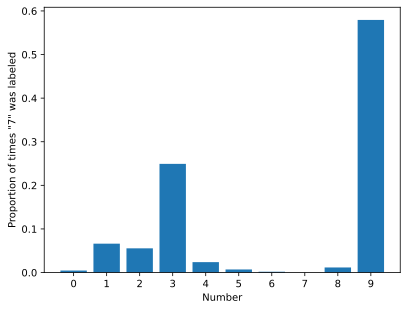

In [90]:
# which numbers are most likely to be confused with 7?
print( np.unique(guesses) )

probMistaken = np.zeros(10)

for i in range(10):
  probMistaken[i] = torch.mean((guesses==i).float()) # finding the prob of image being 1,2,3...

plt.bar(range(10),probMistaken)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Proportion of times "7" was labeled')
plt.show()

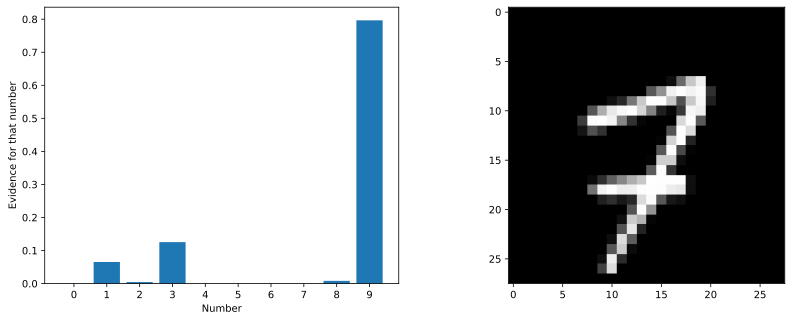

In [93]:
sample2test = 291

fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].bar(range(10), np.exp(predictions[sample2test]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')

ax[1].imshow(np.reshape(rowsWith7NormDataT[sample2test,:], (28, 28)), cmap = 'gray')
plt.show()